# Graph Algorithm Using BSP

The dataset we use is DBLP co-authorship graph.  

In [2]:
# First we connect to database.
%load_ext sql
%sql postgresql://ftian@localhost/ftian

'Connected: ftian@ftian'

In [6]:
nedges = %sql select count(*) from dblp
print(nedges)
nsrc = %sql select count(distinct i) from dblp
print(nsrc)
ndst = %sql select count(distinct j) from dblp
print(ndst)
ntotal = %sql select count(distinct n) from (select i as n from dblp union all select j as n from dblp) tmpt
print(ntotal)


1 rows affected.
+---------+
|  count  |
+---------+
| 1049866 |
+---------+
1 rows affected.
+--------+
| count  |
+--------+
| 189114 |
+--------+
1 rows affected.
+--------+
| count  |
+--------+
| 304374 |
+--------+
1 rows affected.
+--------+
| count  |
+--------+
| 317080 |
+--------+


BSF implemeneted using BSP/Phi

In [19]:
bsf = """
WITH BSF AS (
select 
--
-- Output columns, distant to start node, and count. 
--
dg_utils.transducer_column_int4(1) as dist, 
dg_utils.transducer_column_int4(2) as cnt,

--
-- Transuducer functions, $PHI$ is PostgreSQL dollar quoted string.  #SEGID#
-- is the segment id, 0 is the starting node id.
--
dg_utils.transducer($PHI$PhiExec go #SEGID# 0 

//
// BEGIN INPUT TYPES
// a int32
// b int32
// END INPUT TYPES
//
// BEGIN BSP TYPES
// a int32
// b int32
// END BSP TYPES
//
// BEGIN OUTPUT TYPES
// a int32
// b int32
// END OUTPUT TYPES
//

package main

import (
        "log"
        "os"
        "strconv"
)

type node struct {
        flag int32
        edge []int32
}

func do_x(id string, s string) {
        peers := []string{"localhost:20000", "localhost:20001"}
        myid, _ := strconv.Atoi(id)
        ss, _ := strconv.Atoi(s)
        src := int32(ss)
        // graph data structure.
        graph := make(map[int32]*node)

        // BSP init
        BspInit(peers, myid)

        // 
        // superstep 1: redistribute edges according to src id
        // original input graph is (x, y) where x < y
        // but we double it and put (y, x) in as well.
        //
        // Note here, this is the oridnary PHI NextInput loop
        // 
        for rec := NextInput(); rec != nil; rec = NextInput() {
                var brec, brec2 BspRecord
                a, _ := rec.Get_a()
                b, _ := rec.Get_b()
                brec.Set_a(a)
                brec.Set_b(b)
                if a%2 == 0 {
                        BspSend(0, &brec)
                } else {
                        BspSend(1, &brec)
                }

                brec2.Set_a(b)
                brec2.Set_b(a)
                if b%2 == 0 {
                        BspSend(0, &brec2)
                } else {
                        BspSend(1, &brec2)
                }
        }
        BspSync(false)

        //
        // superstep 2: build graph.  The graph is a map from node id to its out edges.
        // each node also has a flag, initialized to 0 (meaning has not been visisted).
        //
        log.Printf("SuperStep 2: myid %d, build partial graph.", myid)
        for brec := BspNext(); brec != nil; brec = BspNext() {
              a, _ := brec.Get_a()
                if a%2 != int32(myid) {
                        log.Fatalf("Bug: node id %d sent to bsp worker %d.", a, myid)
                }
                b, _ := brec.Get_b()
                if graph[a] != nil {
                        graph[a].edge = append(graph[a].edge, b)
                } else {
                        n := new(node)
                        n.edge = []int32{b}
                        graph[a] = n
                }
        }

        //
        // Start by sending dummy message to myself, this is the begining point of 
        // BSF.
        //
        if src%2 == int32(myid) {
                var brec BspRecord 
                log.Printf("SuperStep 2: myid %d. Sending out a rec to start bsf, from node %d", myid, src)
                brec.Set_a(src)
                BspSend(int32(myid), &brec)
        }

        BspSync(false)

        //
        // Now loop supersteps.   This is the BSF proper.   Basically, we read input from
        // prev superstep, for each node we have not visisted before, we mark the flag of
        // the node to a positive number. 
        // 
        sstep := int32(2)
        totalvisit := 0
        for {
                sstep++
                log.Printf("StepStep %d: running bfs", sstep)
                cnt := 0
                ocnt := 0
                firstvisit := 0
                for brec := BspNext(); brec != nil; brec = BspNext() {
                        cnt++
                        visit, _ := brec.Get_a()
                        if visit%2 != int32(myid) {
                                log.Fatalf("Bug: node id %d sent to bsp worker %d.", visit, myid)
                        }
                        node := graph[visit]
                        if node != nil {
                                if node.flag == 0 {
                                        firstvisit++
                                        node.flag = sstep - 2
                                        for _, dst := range node.edge {
                                                ocnt++
                                                var orec BspRecord
                                                orec.Set_a(dst)
                                                BspSend(dst%2, &orec)
                                        }
                                }
                        } else {
                                log.Fatalf("Invalid node id %d", visit)
                        }
                }

                totalvisit += firstvisit

                log.Printf("Superstep %d, myid %d: recv %d, first time visit %d, totalvisit %d, and output %d.", sstep, myid, cnt, firstvisit, totalvisit, ocnt)
                sync := BspSync(cnt == 0)
                if sync < 0 {
                        log.Printf("Superstep %d sync done!", myid)
                        break
                }
        }
        // Output, we will output the number of nodes that is connect to src
        nodeCnt := make(map[int32]int32)
        for _, node := range graph {
                if node.flag > 0 {
                        oldcnt := nodeCnt[node.flag]
                        nodeCnt[node.flag] = oldcnt + 1
                } else {
                        oldcnt := nodeCnt[-1] 
                        nodeCnt[-1] = oldcnt + 1
                }
        }

        for k, v := range nodeCnt {
                var outrec OutRecord
                outrec.Set_a(int32(k))
                outrec.Set_b(int32(v))
                WriteOutput(&outrec)
        }
        WriteOutput(nil)
}

func main() {
        do_x(os.Args[1], os.Args[2])
}
$PHI$), i, j
from (select i, j from dblp) tmpt
)
select dist, sum(cnt) as cnt from BSF group by dist order by dist
"""


In [20]:
result = %sql $bsf

15 rows affected.


In [17]:
%matplotlib inline

<Container object of 15 artists>

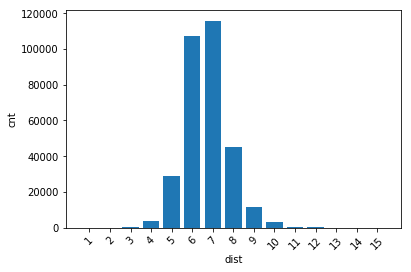

In [21]:
result.bar()

Next we look at SSSP.  We used Bellman-Ford.  We created a table dblpw by adding random weight to each edge.  
```
create table dblpw as select i, j, random() as w from dblp
```

In [28]:
sssp = """
WITH SSSP AS (
select
dg_utils.transducer_column_int4(1) as parent,
dg_utils.transducer_column_int4(2) as id, 
dg_utils.transducer_column_float8(3) as dist,
dg_utils.transducer($PHI$PhiExec go #SEGID# 0
//
// BEGIN INPUT TYPES
// a int32
// b int32
// w float64
// END INPUT TYPES
//
// BEGIN BSP TYPES
// a int32
// b int32
// w float64
// END BSP TYPES
//
// BEGIN OUTPUT TYPES
// a int32
// b int32 
// w float64
// END OUTPUT TYPES
//

package main

import (
        "log"
        "math"
        "os"
        "strconv"
)

type edge_t struct {
        next int32   // next node
        w    float64 // weight
}

type node_t struct {
        sstep int32
        pre   int32    // previous node, used in BF
        w     float64  // accumulated distance.
        edge  []edge_t // incoming edges
}

func do_x(id string, s string) {
        peers := []string{"localhost:20000", "localhost:20001"}
        myid, _ := strconv.Atoi(id)
        ss, _ := strconv.Atoi(s)
        src := int32(ss)

        // graph data structure.
        graph := make(map[int32]*node_t)

        // BSP init
        BspInit(peers, myid)

        //
        // superstep 1: redistribute edges according to node id
        // input was one direction, we flip the edge as well.
        // Note here, this is the oridnary PHI NextInput loop
        //
        for rec := NextInput(); rec != nil; rec = NextInput() {
                var brec BspRecord
                a, _ := rec.Get_a()
                b, _ := rec.Get_b()
                w, _ := rec.Get_w()
                brec.Set_a(a)
                brec.Set_b(b)
                brec.Set_w(w)
                BspSend(a%2, &brec)

                var brec2 BspRecord
                brec2.Set_a(b)
                brec2.Set_b(a)
                brec2.Set_w(w)
                BspSend(b%2, &brec2)
        }
        BspSync(false)

        //
        // superstep 2: build graph.
        // initialize the node data, set pre to -1 and w to inf.
        //
        log.Printf("SuperStep 2: myid %d, build partial graph.", myid)
        for brec := BspNext(); brec != nil; brec = BspNext() {
                a, _ := brec.Get_a()
                b, _ := brec.Get_b()
                w, _ := brec.Get_w()

                var e edge_t 
                e.next = b
                e.w = w
                if graph[a] != nil {
                        graph[a].edge = append(graph[a].edge, e)
                } else {
                        n := new(node_t)
                        n.sstep = 0
                        n.pre = -1
                        if a == src {
                                n.w = 0
                        } else {
                                n.w = math.Inf(1)
                        }

                        n.edge = []edge_t{e}
                        graph[a] = n
                }

                // Send out a message
                if a == src {
                        var rr BspRecord
                        rr.Set_a(a)
                        rr.Set_b(b)
                        rr.Set_w(w)
                        BspSend(b%2, &rr)
                }
        }

        BspSync(false)

        //
        // Now loop supersteps.   BF proper.
        //
        sstep := int32(2)
        for {
                sstep++
                log.Printf("StepStep %d: running Bellman Ford", sstep)
                relaxed := false
                for brec := BspNext(); brec != nil; brec = BspNext() {
                        // For each node, we recieved a update
                        a, _ := brec.Get_a()
                        b, _ := brec.Get_b()
                        w, _ := brec.Get_w()

                        n := graph[b]
                        if n == nil {
                                log.Fatalf("BSP BF Step %d: myid %d got an bad node %d", sstep, myid, b)
                        } 
                        
                        if n.w >= w {
                                // relax edges.
                                n.w = w
                                n.pre = a
                                n.sstep = sstep
                                relaxed = true
                        }
                }

                // If we relaxed an edge in this iteration, the alg need to continue.
                if relaxed {
                        for a, n := range graph {
                                if n.sstep == sstep {
                                        // Relaxed in this iteration.
                                        for _, e := range n.edge {
                                                var rr BspRecord
                                                rr.Set_a(a)
                                                rr.Set_b(e.next)
                                                rr.Set_w(n.w + e.w)
                                                BspSend(e.next%2, &rr)
                                        }
                                }
                        }
                }

                sync := BspSync(!relaxed)
                if sync < 0 {
                        log.Printf("Superstep %d sync done!", myid)
                        break
                }
        }

        // Output, we will output the number of nodes that is connect to src
        for id, n := range graph {
                var outrec OutRecord
                outrec.Set_a(n.pre)
                outrec.Set_b(id) 
                outrec.Set_w(n.w)
                WriteOutput(&outrec)
        }
        WriteOutput(nil)
}

func main() {
        do_x(os.Args[1], os.Args[2])
}

$PHI$), i, j, w
from dblpw )
select parent, id, dist from SSSP order by dist limit 10
"""

In [29]:
result = %sql $sssp

10 rows affected.


In [30]:
print(result)

+--------+--------+--------------------+
| parent |   id   |        dist        |
+--------+--------+--------------------+
|   -1   |   0    |        0.0         |
|   0    | 23073  | 0.0517750196158886 |
| 23073  | 14442  | 0.0617059296928346 |
| 14442  | 31959  | 0.0676179388538003 |
| 23073  | 94348  | 0.0704396432265639 |
| 23073  | 108455 | 0.0837488444522023 |
|   0    | 33971  | 0.0903840456157923 |
| 23073  | 170147 | 0.0928031872026622 |
| 14442  | 11567  | 0.104765699710697  |
| 23073  | 126488 | 0.109074627049267  |
+--------+--------+--------------------+
